In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
def get_drawdown(p):
    """
    计算净值回撤
    """
    T = len(p)
    hmax = [p[0]]
    for t in range(1, T):
        hmax.append(np.nanmax([p[t], hmax[t - 1]]))
    dd = [p[t] / hmax[t] - 1 for t in range(T)]

    return dd


def cal_period_perf_indicator(adjnav):
    """
    计算区间业绩指标:输入必须是日频净值
    """

    if type(adjnav) == pd.DataFrame:
        res = pd.DataFrame(index=adjnav.columns, columns=['AnnRet', 'AnnVol', 'SR', 'MaxDD', 'Calmar'])
        for col in adjnav:
            res.loc[col] = cal_period_perf_indicator(adjnav[col])

        return res

    ret = adjnav.pct_change()
    #annret = np.nanmean(ret) * 242 # 单利
    annret = (adjnav[-1] / adjnav[0]) ** (242/len(adjnav)) - 1 # 复利
    annvol = np.nanstd(ret) * np.sqrt(242)
    sr = annret / annvol
    dd = get_drawdown(adjnav)
    mdd = np.nanmin(dd)
    calmar = annret / -mdd

    return [annret, annvol, sr, mdd, calmar]

def datestr2dtdate(datestr):
    # 日期格式转换：'yyyy-mm-dd'转为datetime.date
    return datetime.datetime.strptime(datestr, '%Y-%m-%d').date()

In [6]:
# 从csv文件获取指数价格数据
index_price = pd.read_csv('./300和500历史数据.csv').set_index('datetime')
index_price.index = [datestr2dtdate(e) for e in index_price.index]

index_price

,csi500,hs300
2004-12-31,1000.0000,1000.0000
2005-01-04,986.9270,982.7940
2005-01-05,1003.6330,992.5640
2005-01-06,994.5950,983.1740
2005-01-07,997.6060,983.9580
...,...,...
2021-08-16,7052.4876,4941.0676
2021-08-17,6894.4042,4837.4034
2021-08-18,6941.0080,4894.2384
2021-08-19,6947.0564,4862.1394


              csi500     hs300   ret_300   ret_500  N_day_ret_300  \
2004-12-31  1.000000  1.000000       NaN       NaN            NaN   
2005-01-04  0.986927  0.982794 -0.017206 -0.013073            NaN   
2005-01-05  1.003633  0.992564  0.009941  0.016927            NaN   
2005-01-06  0.994595  0.983174 -0.009460 -0.009005            NaN   
2005-01-07  0.997606  0.983958  0.000797  0.003027            NaN   
...              ...       ...       ...       ...            ...   
2021-08-16  7.052488  4.941068 -0.000994 -0.005135      -0.033720   
2021-08-17  6.894404  4.837403 -0.020980 -0.022415      -0.053159   
2021-08-18  6.941008  4.894238  0.011749  0.006760      -0.048562   
2021-08-19  6.947056  4.862139 -0.006559  0.000871      -0.056216   
2021-08-20  6.920025  4.769268 -0.019101 -0.003891      -0.062870   

            N_day_ret_500  momentum_300_vs_500  wgt_300  wgt_500  ret_stgy  \
2004-12-31            NaN                  NaN        0        1       NaN   
2005-01-04     

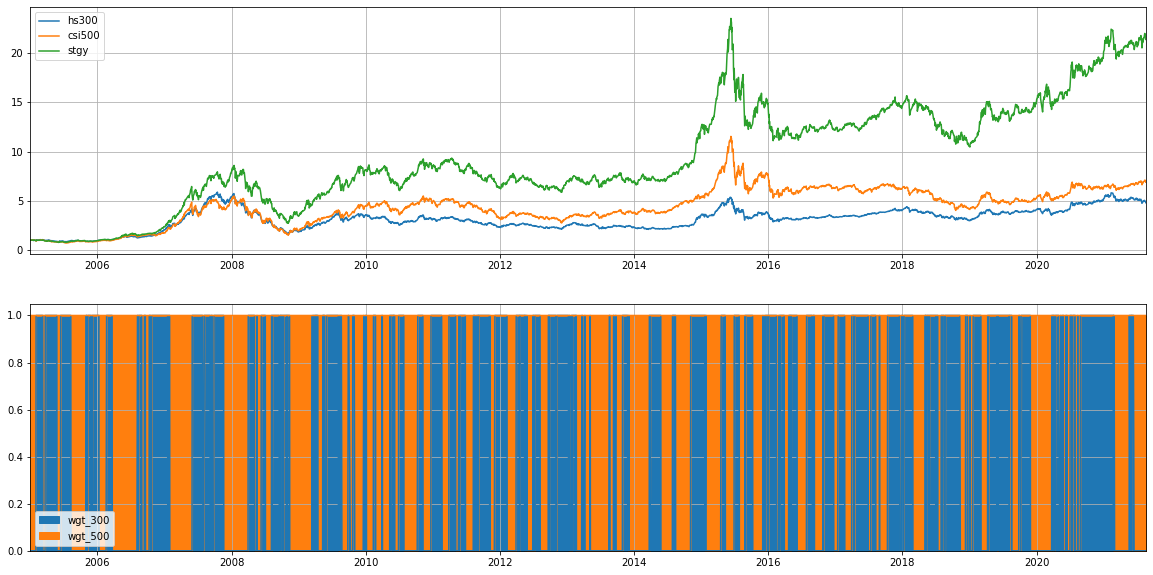

In [7]:
# 二八轮动：满仓版本
N = 20
df = index_price.copy()
df['ret_300'] = df['hs300'].pct_change()
df['ret_500'] = df['csi500'].pct_change()
df['N_day_ret_300'] = df['hs300'] / df['hs300'].shift(N) - 1
df['N_day_ret_500'] = df['csi500'] / df['csi500'].shift(N) - 1        
df['momentum_300_vs_500'] = df['N_day_ret_300'] - df['N_day_ret_500']
df['wgt_300'] = [1 if e>0 else 0 for e in df['momentum_300_vs_500'].shift(1)]
df['wgt_500'] = 1 - df['wgt_300']
df['ret_stgy'] = df['ret_300'] * df['wgt_300'] + df['ret_500'] * df['wgt_500']
df['hs300'] = (1+df['ret_300']).cumprod().fillna(1)
df['csi500'] = (1+df['ret_500']).cumprod().fillna(1)
df['stgy'] = (1+df['ret_stgy']).cumprod().fillna(1)

print(df)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,['hs300', 'csi500', 'stgy']].plot(ax=ax1, grid=True)
plt.xlim(df.index[0],df.index[-1])

ax2 = fig.add_subplot(2,1,2)
df[['wgt_300', 'wgt_500']].plot(ax=ax2, kind='area', stacked=True, grid=True)
plt.xlim(df.index[0],df.index[-1])
    
res = cal_period_perf_indicator(df.loc[:,['hs300', 'csi500', 'stgy']])
print(res)

              csi500     hs300   ret_300   ret_500  N_day_ret_300  \
2004-12-31  1.000000  1.000000       NaN       NaN            NaN   
2005-01-04  0.986927  0.982794 -0.017206 -0.013073            NaN   
2005-01-05  1.003633  0.992564  0.009941  0.016927            NaN   
2005-01-06  0.994595  0.983174 -0.009460 -0.009005            NaN   
2005-01-07  0.997606  0.983958  0.000797  0.003027            NaN   
...              ...       ...       ...       ...            ...   
2021-08-16  7.052488  4.941068 -0.000994 -0.005135      -0.033720   
2021-08-17  6.894404  4.837403 -0.020980 -0.022415      -0.053159   
2021-08-18  6.941008  4.894238  0.011749  0.006760      -0.048562   
2021-08-19  6.947056  4.862139 -0.006559  0.000871      -0.056216   
2021-08-20  6.920025  4.769268 -0.019101 -0.003891      -0.062870   

            N_day_ret_500  wgt_300  wgt_500  ret_stgy       stgy  
2004-12-31            NaN        0        0       NaN   1.000000  
2005-01-04            NaN        0   

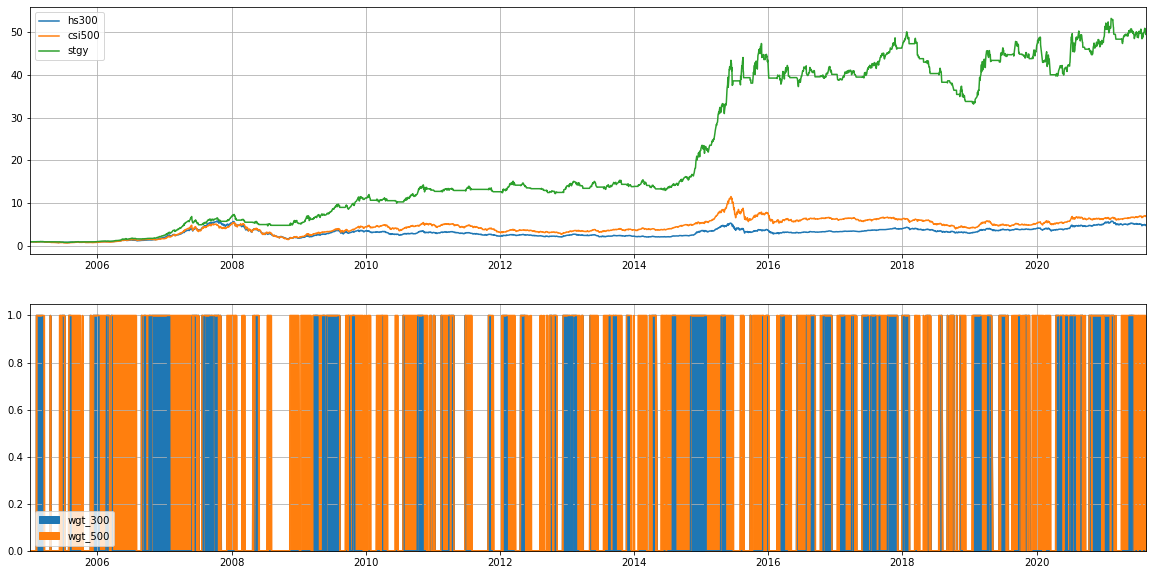

In [8]:
# 二八轮动：有空仓版
N = 20
df = index_price.copy()
df['ret_300'] = df['hs300'].pct_change()
df['ret_500'] = df['csi500'].pct_change()
df['N_day_ret_300'] = df['hs300'] / df['hs300'].shift(N) - 1
df['N_day_ret_500'] = df['csi500'] / df['csi500'].shift(N) - 1

df['wgt_300'] = 0
df['wgt_500'] = 0
for i in range(1,len(df)):
    t = df.index[i]
    t0 = df.index[i-1]
    if df.loc[t0,'N_day_ret_300']>=df.loc[t0,'N_day_ret_500'] and df.loc[t0,'N_day_ret_300']>0:
        df.loc[t,'wgt_300'] = 1
    elif df.loc[t0,'N_day_ret_500']>df.loc[t0,'N_day_ret_300'] and df.loc[t0,'N_day_ret_500']>0:
        df.loc[t,'wgt_500'] = 1
        
df['ret_stgy'] = df['ret_300'] * df['wgt_300'] + df['ret_500'] * df['wgt_500']
df['hs300'] = (1+df['ret_300']).cumprod().fillna(1)
df['csi500'] = (1+df['ret_500']).cumprod().fillna(1)
df['stgy'] = (1+df['ret_stgy']).cumprod().fillna(1)

print(df)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,['hs300', 'csi500', 'stgy']].plot(ax=ax1, grid=True)
plt.xlim(df.index[0],df.index[-1])

ax2 = fig.add_subplot(2,1,2)
df[['wgt_300', 'wgt_500']].plot(ax=ax2, kind='area', stacked=True, grid=True)
plt.xlim(df.index[0],df.index[-1])
    
res = cal_period_perf_indicator(df.loc[:,['hs300', 'csi500', 'stgy']])
print(res)